# Photogrammetric Optode Coregistration

In [28]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import logging
logging.basicConfig()
logging.getLogger("cedalion").setLevel(logging.DEBUG)
logging.getLogger('trame_client').setLevel(logging.WARNING)
logging.getLogger('trame_server').setLevel(logging.WARNING)

import cedalion
import cedalion.io
import cedalion.datasets
import cedalion.plots
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor, geo3d_from_scan
import xarray as xr
import pyvista as pv
import numpy as np
import cedalion.geometry.registration
import cedalion.dataclasses as cdc
from cedalion.plots import OptodeSelector


from cedalion.geometry.landmarks import order_ref_points_6
from cedalion.geometry.registration import icp_with_full_transform, find_spread_points

xr.set_options(display_expand_data=False);


## Choose between interactive and static 3D plots
Note that for optode and landmark picking you need interactive plots. Static plots are mainly useful for rendering this example notebook. 

In [29]:
pv.set_jupyter_backend("static")  # uncomment for static rendering (used for documentation page)
#pv.set_jupyter_backend("server")  # uncomment for interactive rendering

Use `cedalion.io.read_einstar_obj` to read the textured triangle mesh produced by the Einstar scanner. Here, we use our example dataset.

In [30]:
""" 
# insert here your own file if you do not want to use the example file
fname_scan = "" # path to .obj scan file
"""
fname_scan, fname_snirf,fname_montage = cedalion.datasets.get_photogrammetry_example_scan()
s = cedalion.io.read_einstar_obj(fname_scan)

Processors are meant to analyze the textured mesh and extract positions. The ColoredStickerProcessor searches for colored circular areas. The colors must be specified by their ranges in hue and value. These can for example be found by usig a color pipette tool on the texture file.

In the following to classes of stickers are searched: "O(ptodes)" in blue and "L(andmarks" in yellow.

In [31]:
processor = ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)

sticker_centers, normals, details = processor.process(s, details=True)
display(sticker_centers)

[[ 89.200134   6.045319 647.938599]
 [ 89.200134   5.245316 647.979248]
 [ 91.200134   8.845306 647.925781]
 ...
 [124.331436  49.604759 453.649017]
 [122.423584  49.688946 453.390503]
 [124.424706  48.602425 456.144684]]
[[ 91.200134   8.845306 647.925781]
 [ 89.600143   3.965302 647.806641]
 [ 90.320129   3.245316 647.687866]
 ...
 [ 34.000137 -95.936989 536.323303]
 [ 34.80014  -96.269691 536.323303]
 [ 34.400146 -96.094498 536.323303]]
O (0.11, 0.21, 0.7, 1)
[5.23597512e-01 4.48759255e-01 9.35151147e-02 8.64858158e-03
 8.93259517e-03 2.66685081e-01 3.78303003e-02 1.34638162e-01
 2.01041160e-01 2.07950339e-01 5.99867454e-01 1.55061135e-01
 1.32573142e-01 5.40860085e-01 6.75715112e-02 2.75196633e-01
 2.31770730e-01 2.32193093e-01 1.79171853e-01 3.81408591e-01
 6.27900170e-02 2.58908591e-01 2.33859153e-01 3.07162376e-01
 1.87056374e-01 1.54202371e-01 1.68405862e-01 3.98049276e-04
 4.17392068e-01 1.59042458e-01 1.19970803e-01 2.37379250e-01
 1.54202981e-01 1.85352073e-01 2.54031272e-01

Magnitude,[[168.20800230807404 -1.8542108363720295 604.6952759385473] [66.56813666707946 -45.446009833327295 413.9116547361825] [72.74932584350579 -29.724508573184753 641.0411088944243] [174.09489704802849 30.948763920617235 590.2912304026613] [64.59588202269265 36.73775356319982 418.67725227545077] [144.9400539820526 65.70424668831195 477.1103808349129] [96.7753171518988 -85.21918292936479 443.1992388260486] [139.62419887256908 18.086516357791357 626.7501671183902] [199.1804175979135 6.0338580332486735 561.7040996445675] [190.96329158056932 34.08355597040105 510.04141537050833] [135.83605529999295 -97.85017602938836 566.3646801654892] [46.676526127434016 3.147658905039954 412.5760727296321] [189.67457753858292 39.83345850113124 550.3463872975028] [144.4659485502365 -72.04491281628765 597.860839577174] [105.07198426809191 -43.816575996094386 631.4605555075025] [29.303523309962397 -27.036486918542792 420.43909301498206] [147.33691790825134 45.670306474859174 612.156834923346] [16.22639620342907 -83.1799570611303 467.8343191590291] [102.78412742807943 37.43423930925347 426.0744647758352] [100.15608710072235 77.19437476666994 463.1975258620709] [61.29097803632788 -109.31909858043358 517.0502394785331] [111.62177054811374 -73.90120586070873 609.2506264642934] [116.95076429984425 61.27278976620883 624.1765562895738] [64.4215856054848 -84.55994000819737 594.0332404747] [128.1552835116019 55.788931173973296 450.1311940977989] [43.965531168597735 -100.09659790228122 483.6539100443728] [116.70387239625956 12.759983359276797 421.62807468897] [78.3754254672294 -106.79744445716787 547.5258597918365] [95.80710218419836 -109.1114094717603 494.9793019235261] [125.94120889298381 -11.761543101766982 635.017380047836] [120.31909306315049 -108.52657525400949 522.8193739257814] [80.42155894459486 59.50201651233196 436.93303420842204] [42.95823468722986 -73.32440584000989 438.1874597568891] [148.60516266351388 -32.35315058669119 617.1975998026194] [168.38731045575835 66.93132197125097 547.0832667563633] [71.60191765737925 -99.43700093517054 464.80959110265985] [128.37889292744086 -93.7535448838735 469.63747493690164] [147.04724836104788 20.18315578739831 442.59616279819085] [119.31191711406407 -25.481229025252407 418.14077783642136] [170.92197367717236 28.028798737374924 469.96515978621125] [19.59649603488138 -56.786228672527386 436.2540301335909] [94.48786070540265 -96.69047494106775 581.3846425347579] [149.97451406849999 71.48375896677855 584.011407952017] [114.27173620444553 84.95538349678266 488.07301453957734] [81.85392704993178 -66.8301279787699 615.612962560712] [160.5849081328448 73.76911337852893 510.6595383646287] [139.3102258625189 86.84103946410589 552.2580296431537] [19.110335106641685 -90.48101860034394 502.06383150131876] [182.01618787767472 -19.122184714022428 473.2037050414747] [157.56481022862445 -20.109787034291944 442.4466497202951] [45.55281114010628 -92.6444925812716 560.7418282253959] [119.73924617808483 85.66437733591181 598.0533206004241] [77.12146173217742 -0.98904429691827 408.77347211568747] [174.52698261893838 -51.99584906039722 586.0400269047352] [95.16460366075229 4.361589686509797 646.754501271336] [31.748821909855103 -95.50783496645072 532.6183383804292] [129.5812199083526 92.97881107313542 522.6067785904106] [110.10377972666198 -58.62363699051901 425.69462514996724] [178.22381271095452 -77.00704632800736 545.2346712194258] [157.41260423176402 -89.01020179500902 501.7346986317448] [203.47900997527344 -9.859533890159675 514.203376596728]]
Units,millimeter


Visualize the surface and extraced results.

In [32]:
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(pvplt, sticker_centers, normals)
pvplt.show()

INFO:wslink.backends.aiohttp:awaiting runner setup
INFO:wslink.backends.aiohttp:awaiting site startup
INFO:wslink.backends.aiohttp:Print WSLINK_READY_MSG
INFO:wslink.backends.aiohttp:Schedule auto shutdown with timout 0
INFO:wslink.backends.aiohttp:awaiting running future


Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x18126af0dd0_10&reconnect=auto" class="pyvi…

INFO:aiohttp.access:127.0.0.1 [08/Sep/2024:16:58:29 +0100] "GET /index.html?ui=P_0x1810af71c50_19&reconnect=auto HTTP/1.1" 200 236 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.93.0 Chrome/124.0.6367.243 Electron/30.4.0 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Sep/2024:16:58:29 +0100] "GET /vue.global.js HTTP/1.1" 200 253 "http://localhost:58946/index.html?ui=P_0x1810af71c50_19&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.93.0 Chrome/124.0.6367.243 Electron/30.4.0 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Sep/2024:16:58:29 +0100] "GET /assets/index-e80c1ba5.css HTTP/1.1" 200 235 "http://localhost:58946/index.html?ui=P_0x1810af71c50_19&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.93.0 Chrome/124.0.6367.243 Electron/30.4.0 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Sep/2024:16:58:29 +0100] "GET /assets/

The details object is meant as a container for debuging information. It also provides plotting functionality.The following scatter plot shows the vertex colors in the hue-value plane in which the vertex classification operates.

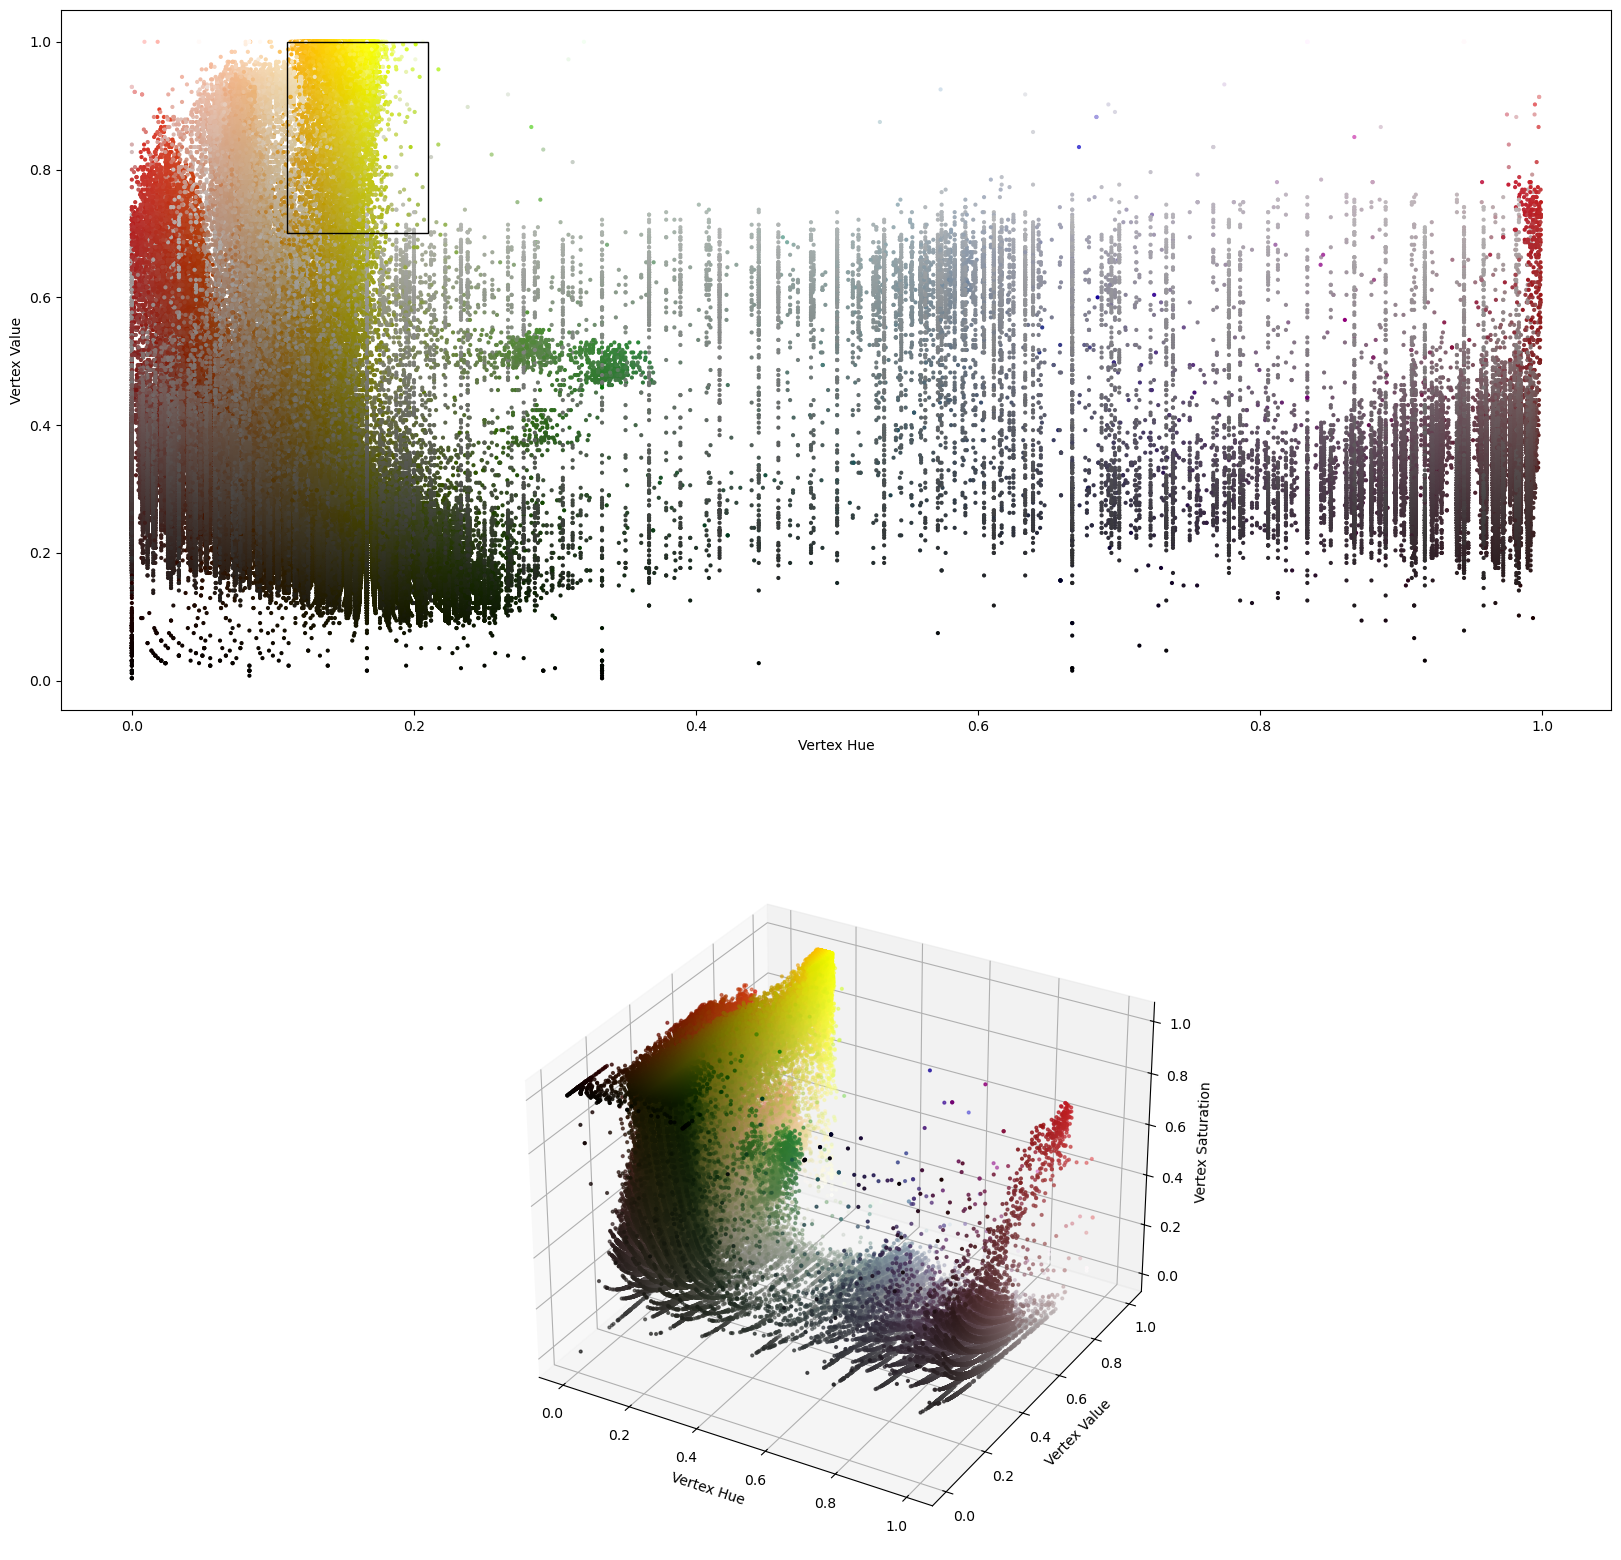

In [33]:
details.plot_vertex_colors()

The following plots show for each cluster (tentative group of sticker vertices) The vertex positions perpendicular to the sticker normal as well as the minimum enclosing circle which is used to find the sticker's center.

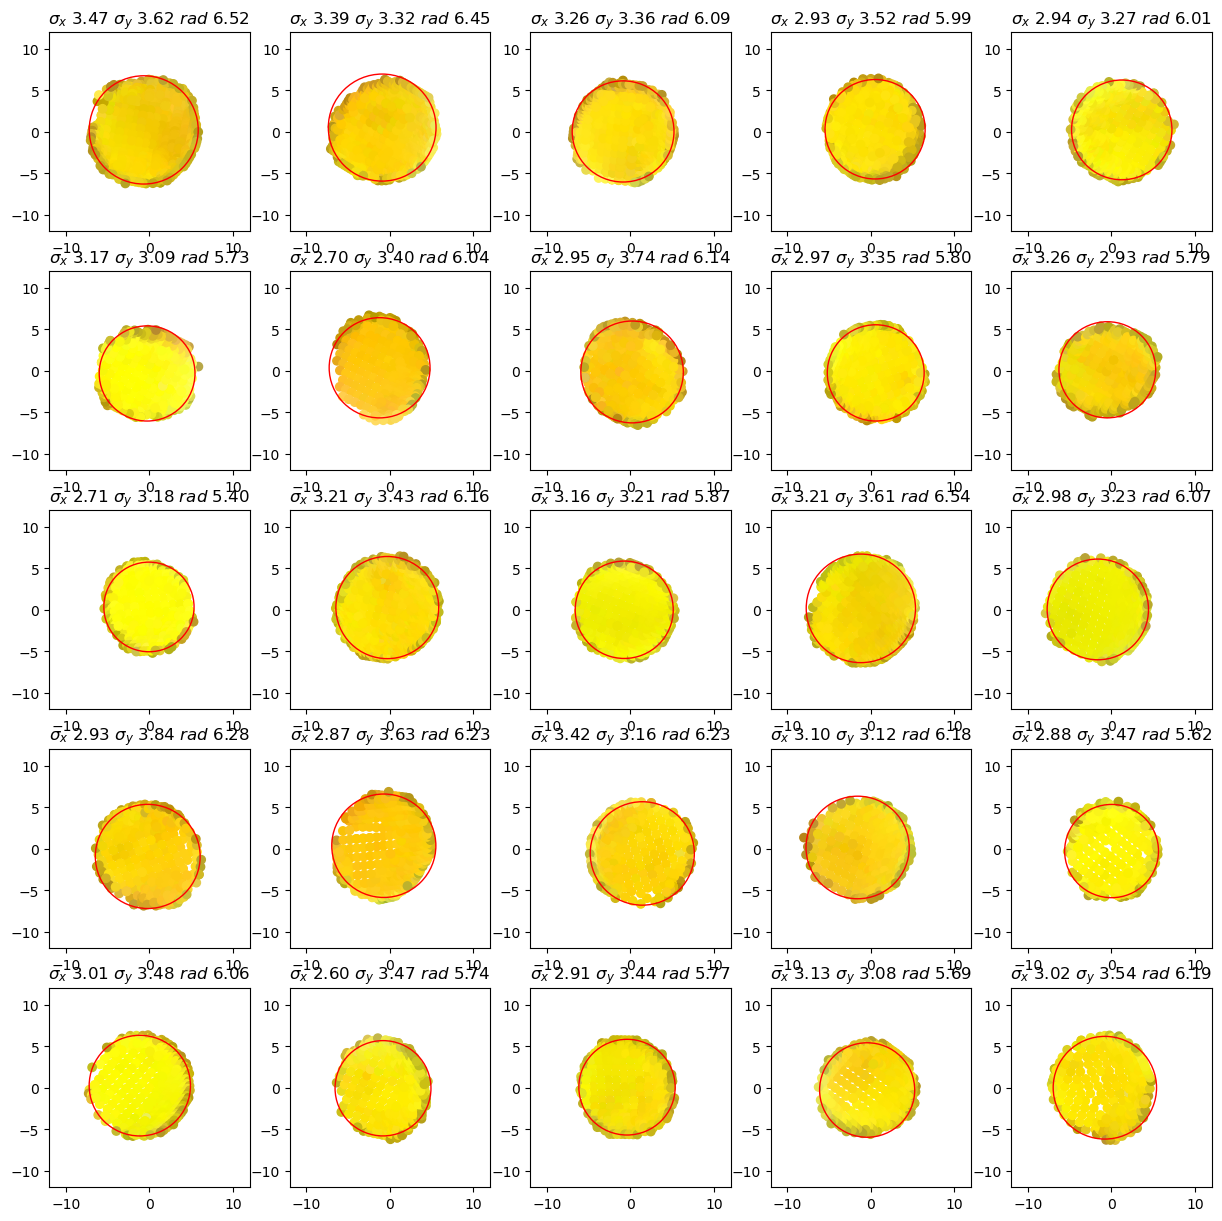

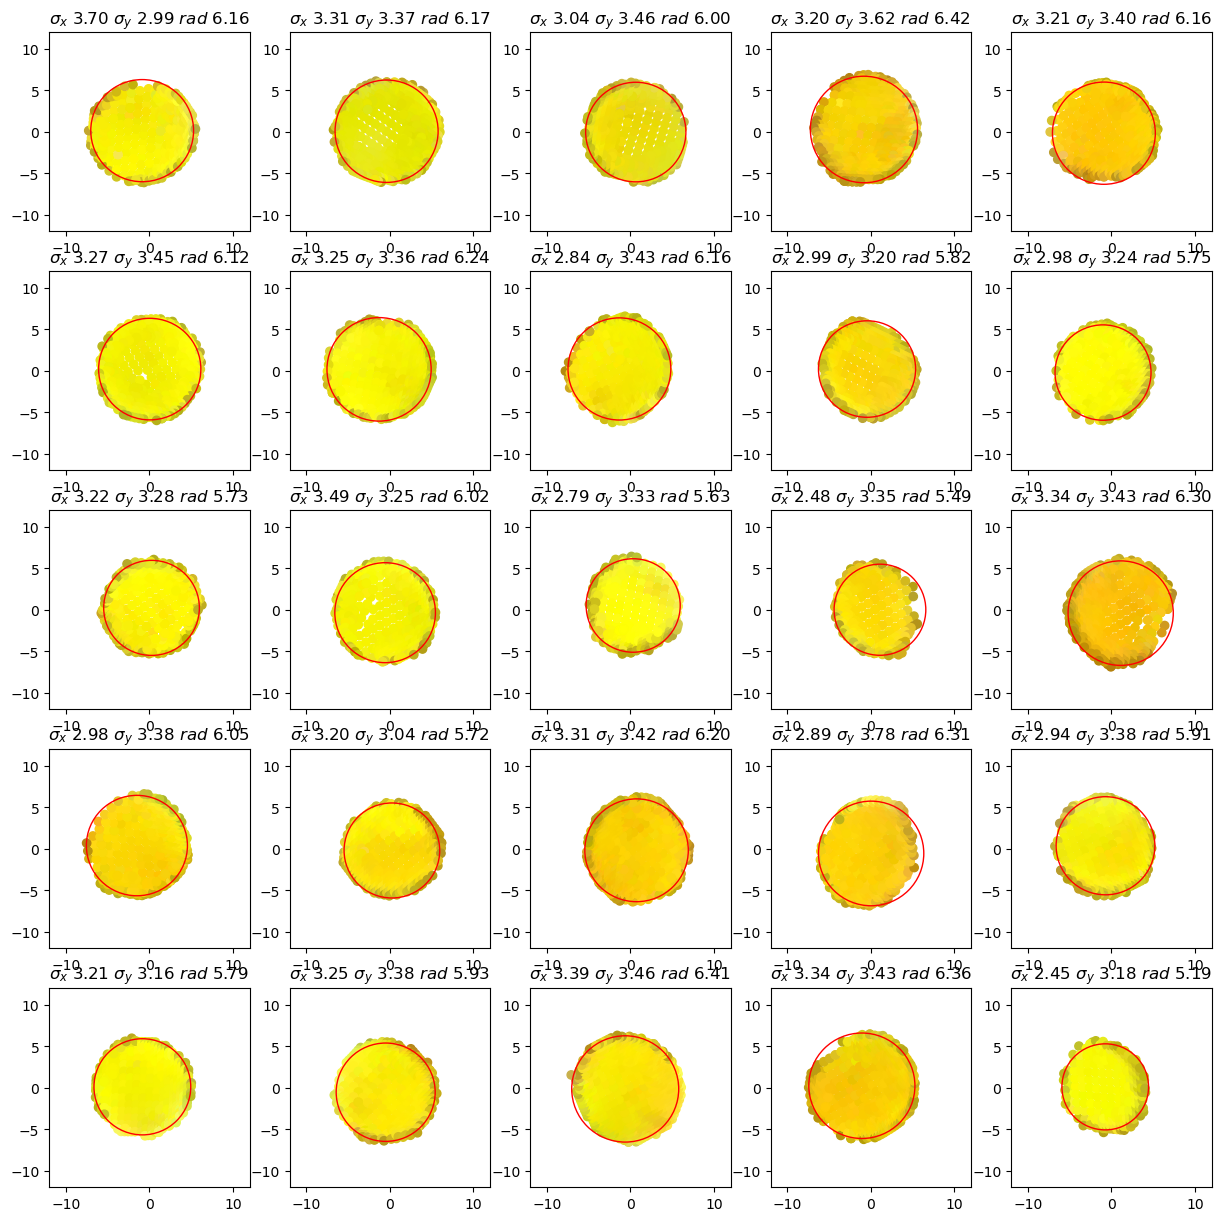

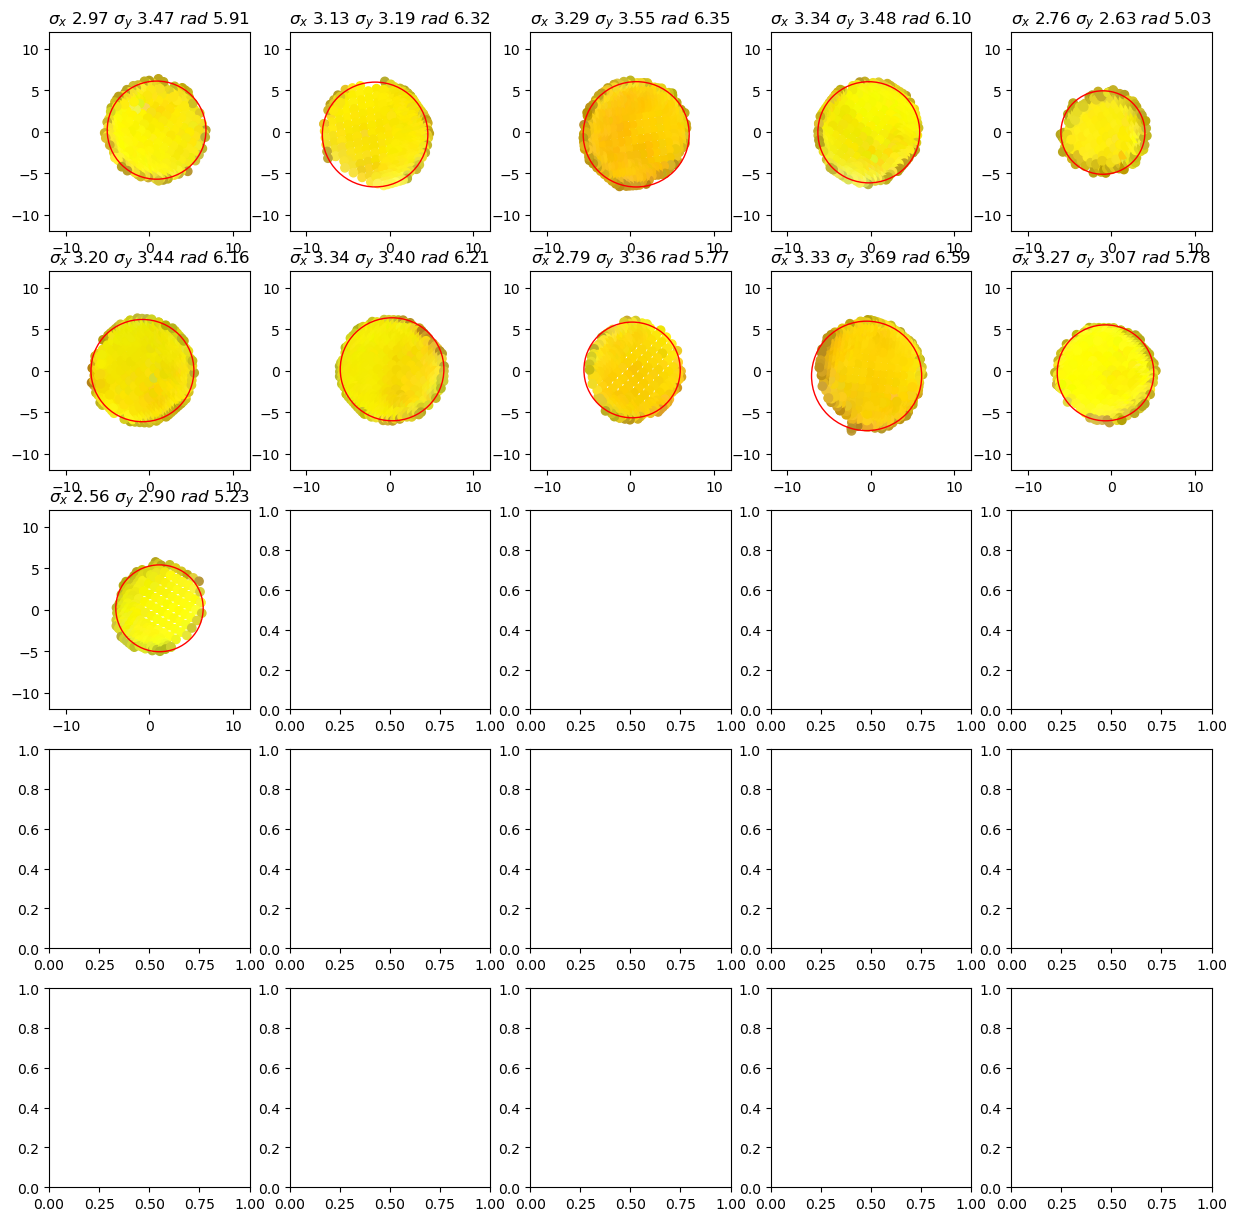

In [34]:
details.plot_cluster_circles()

### If not all optodes were found automatically, there's way to remove or add them manually

In [35]:
visualizer = OptodeSelector(s, sticker_centers, normals)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, s, opacity=1.0)
visualizer.plotter.show()

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x181720453d0_11&reconnect=auto" class="pyvi…

After selecting all optodes, update sticker_centers and normals:

In [36]:
sticker_centers = visualizer.points
normals = visualizer.normals if visualizer.normals is not None else normals

Finally, to get from the sticker centers to the scalp coordinates we have to subtract the lenght of the optodes in the direction of the normals:

In [37]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]
# we make a copy of this raw set of scalp coordinates to use later in the 2nd case of the coregistration example 
# that showcases an alternative route if landmark-based coregistration fails
scalp_coords_altcase = scalp_coords.copy()

display(scalp_coords)

Magnitude,[[152.44412012382006 -3.164419740955468 588.5539200132445] [68.82092127727654 -37.569318961928424 434.9744822390721] [70.87574146428805 -19.86301983465681 620.7926343485767] [158.83224782062874 22.883112000514632 575.7050452377493] [62.593568754130345 27.423212955360874 439.170911656817] [134.62716934826975 49.20327807911198 488.6048336487045] [93.21418330326024 -68.20728715625407 457.64478235742524] [126.66436042794625 14.470945891862922 608.5916914749013] [178.64528522382864 1.4692050349097991 553.443816272699] [170.8086471442527 25.51549154090839 515.6216106697531] [129.10343248182622 -77.87197490010442 558.2219981978461] [48.44956009564793 2.595744401266775 435.0996546145829] [170.28825681621856 29.117417416844333 545.8634159246852] [135.10766002678176 -57.81461758475878 583.0054993409054] [100.80464568851362 -33.522587842912905 611.7988254374043] [38.20145155760907 -22.628224947410867 440.74067175392753] [134.67081587726884 36.52502191624137 595.8260777552705] [23.46108512440398 -63.17549317020054 475.46587867548516] [95.88477630635637 28.490397591645923 445.64910779760095] [94.01348547870164 58.564420401573784 474.4204152256699] [67.30558342532609 -87.56351589052737 515.9192470659646] [109.494070591368 -58.31216962515892 593.026729209294] [106.97042878170434 50.42617754213214 607.0446005866814] [66.90500686446332 -66.76176683775302 580.3285824838807] [118.64246202162931 40.89969992349486 464.22292997630916] [51.32110332943924 -79.4612433232953 489.207080272826] [107.98468704276941 6.2203678711689125 441.4262876396174] [83.48799856451505 -85.33493541133517 542.6286869561628] [93.78590669281559 -86.99323495145177 499.1579529827543] [117.60849249581455 -9.665807236751684 614.1144202423818] [114.17594186073073 -86.88634149643036 524.9923847912723] [78.36455272469053 44.203054386451505 453.4397141678249] [52.34953018137972 -59.66480596243724 453.5490644948772] [136.6625999412149 -28.886374145952857 598.3265463944523] [153.6128780564261 49.95000721784527 545.0556828435924] [73.65588027294808 -78.63720901610861 473.4066774519745] [121.55403422535707 -74.60013713650775 479.5029843185677] [133.38456049106284 13.350079218997191 459.25149301940627] [109.80004104361402 -23.5971118079198 438.55484935416985] [154.36752253331733 21.89574358662338 484.07529025490487] [27.914629073012243 -45.769518101888565 454.14818423381956] [96.59198350521683 -77.36996173101782 569.8498934458705] [134.4344272188825 56.91941611902522 576.4519358726028] [107.4672543531811 65.63509539491533 497.62212415234524] [83.18630135704815 -51.21217491451768 599.3321664871611] [147.84349773412487 55.84996599676812 515.8864512357341] [128.27534958464182 67.13203317816135 551.5187213498523] [29.111726409300424 -70.42798952944844 504.9978044209147] [164.1915407824059 -17.54755502694654 487.008142635151] [141.89017301479365 -20.564355169267778 458.72114252423387] [52.82109620356994 -72.02689459604203 555.0106254235673] [108.58237112696482 69.04657126550275 587.55890968318] [77.31824086614124 -4.673318918637622 431.07027454303545] [159.0523605947828 -44.57708202369032 571.3343147878538] [90.61983684838941 5.337341687967279 624.6376976448421] [39.92757477363445 -74.71870183455349 529.2007448970737] [119.71166169301058 72.82136867213734 525.2580681793502] [104.5711921280963 -48.01102167830971 444.8655111675528] [161.68849708035333 -61.76702054381555 542.9796876067214] [145.1742988766962 -70.83412588211264 507.2677038228454] [181.4666819954097 -9.017642628750986 519.2539840860179]]
Units,millimeter


In [38]:
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=0.3)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(pvplt, sticker_centers, normals)
pvplt.show()

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x18118cc9c10_12&reconnect=auto" class="pyvi…

### Select landmarks on a head surface
* pick_landmarks parameter is set to *True*

In [39]:
pvplt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(pvplt, s, opacity=1.0, pick_landmarks = True)
pvplt.show(interactive = True)

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x181700bf510_13&reconnect=auto" class="pyvi…

### Get landmarks from the plot
Call *get_landmarks* from the previous cell. 
* 1st value - coordinates of picked landmarks
* 2nd - labels of corresponding landmarks

In [40]:
# for documentation purposes and to enable automatically rendered example notebooks we provide the hand-picked coordinates here too.
landmark_labels = ['Nz', 'Iz', 'Cz', 'Lpa', 'Rpa']
landmark_coordinates = [np.array([14.00420712, -7.84856869, 449.77840004]), 
                                  np.array([99.09920059, 29.72154755, 620.73876117]),
                                  np.array([161.63815139, -48.49738938, 494.91210993]),
                                  np.array([82.8771277, 79.79500128, 498.3338802]),
                                  np.array([15.17214095, -60.56186128, 563.29621021])]

# uncomment if you want to use your manually picked landmarks
# landmark_coordinates, landmark_labels = get_landmarks()
landmark_labels

['Nz', 'Iz', 'Cz', 'Lpa', 'Rpa']

### Write landmarks to xarray.DataArray structure

* insert *landmark_coordinates* and *landmark_labels*

In [41]:
coordinates = landmark_coordinates
labels = landmark_labels

types = [cdc.PointType.LANDMARK]*5
groups = ["L"]*5

landmarks = xr.DataArray(
    np.vstack(coordinates),
    dims=["label", "digitized"],
    coords={
        "label": ("label", labels),
        "type": ("label", types),
        "group": ("label", groups),
    },
).pint.quantify("mm")

display(landmarks)

Magnitude,[[14.00420712 -7.84856869 449.77840004] [99.09920059 29.72154755 620.73876117] [161.63815139 -48.49738938 494.91210993] [82.8771277 79.79500128 498.3338802] [15.17214095 -60.56186128 563.29621021]]
Units,millimeter


### Load the montage information from .snirf file


In [42]:
""" 
# insert here your own file if you do not want to use the example file
fname_snirf = "" # path to .snirf file 
"""
# read the example snirf file
recording = cedalion.io.read_snirf(fname_snirf)
rec = recording[0]

# read 3D coordinates of the optodes
montage_elements = rec.geo3d
montage_elements = montage_elements.rename({"pos" : "aligned"})
montage_elements

INFO:root:Loading from file C:\Users\avonl\AppData\Local\cedalion\cedalion\Cache\photogrammetry_example_scan.zip.unzip\photogrammetry_example_scan\photogrammetry_example_31x30.snirf
INFO:root:IndexedGroup MeasurementList at /nirs/data1 in C:\Users\avonl\AppData\Local\cedalion\cedalion\Cache\photogrammetry_example_scan.zip.unzip\photogrammetry_example_scan\photogrammetry_example_31x30.snirf initalized with 194 instances of <class 'snirf.pysnirf2.MeasurementListElement'>
INFO:root:IndexedGroup Data at /nirs in C:\Users\avonl\AppData\Local\cedalion\cedalion\Cache\photogrammetry_example_scan.zip.unzip\photogrammetry_example_scan\photogrammetry_example_31x30.snirf initalized with 1 instances of <class 'snirf.pysnirf2.DataElement'>
INFO:root:IndexedGroup Stim at /nirs in C:\Users\avonl\AppData\Local\cedalion\cedalion\Cache\photogrammetry_example_scan.zip.unzip\photogrammetry_example_scan\photogrammetry_example_31x30.snirf initalized with 0 instances of <class 'snirf.pysnirf2.StimElement'>
IN

Magnitude,[[0.181 89.249 -7.826] [-54.498 68.788 -18.293] [-35.609 78.819 16.092] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


### Find a transformation to align selected landmarks to montage coordinates

Visualization of initial alignment of optode positions from .snirf file

* Blue for detectors
* Red for sources


In [43]:
trafo = cedalion.geometry.registration.register_trans_rot(landmarks, montage_elements)


filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
pvplt.show()


Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x1811904f590_14&reconnect=auto" class="pyvi…

### Iterative closest point algorithm to find labels for detectes optode centers

Visualization of labels assignment

* Green points represent optode centers
* Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)

In [44]:
# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords = scalp_coords.assign_coords(label=labels)


## visualize results
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="green", show_labels = True)
pvplt.show(interactive = True)

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x18118ffb310_15&reconnect=auto" class="pyvi…

Extract labels for detected optodes

### Combine all coregistered points into a new geo3d for further use 
e.g. (to save or update an existing geo3D field in a recording  container)

In [45]:
geo3Dscan = geo3d_from_scan(scalp_coords, landmarks)

Visualization of successfull assignment *(show_labels = True)*

In [46]:
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, geo3Dscan, show_labels = True)
pvplt.show()

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x18118ff6b90_16&reconnect=auto" class="pyvi…

## If labels are wrong (e.g. landmarks are faulty)

It is possible to find a new transformation by manually labeling 3 optodes by selecting them in a given order. For that you need the montage of your experiment.

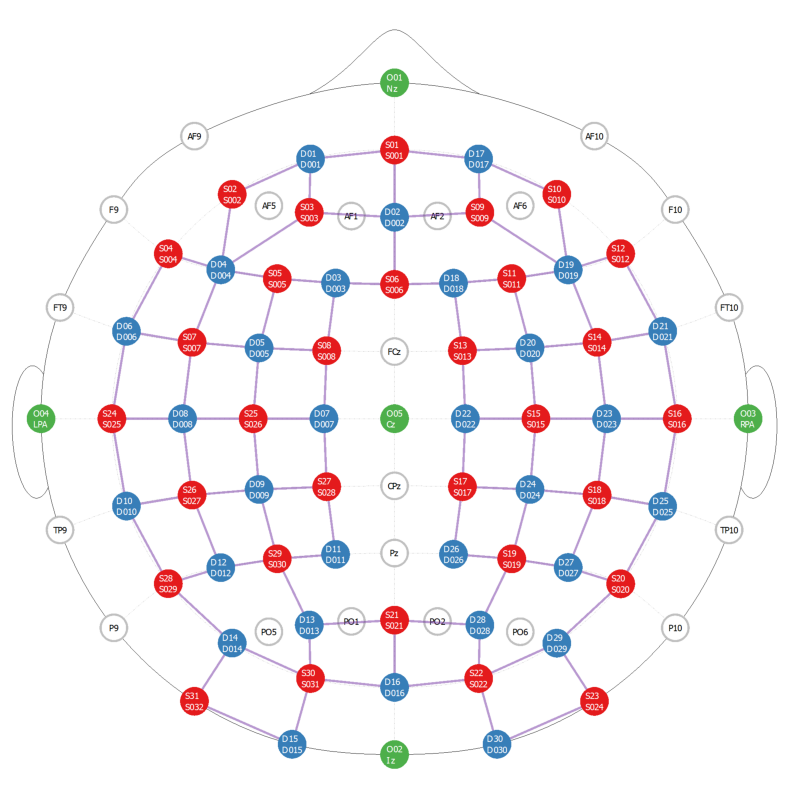

In [47]:
# show montage (png image) in fname_montage
# Load the image
img = mpimg.imread(fname_montage)

# Display the image
plt.figure(figsize=(12, 10)) 
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

Determination of evenly spreaded optodes across the head surface:

In [48]:
spread_point_labels = find_spread_points(filtered_montage_elements)
print("Select those points")
print(spread_point_labels)

points = []
pvplt = pv.Plotter()
cedalion.plots.plot_surface(pvplt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(pvplt, sticker_centers, color="r", ppoints = points)
#cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
pvplt.show()

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Select those points
['S1' 'D30' 'S31']


Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x1811eb93310_17&reconnect=auto" class="pyvi…

(index of points for debugging purposes)

In [49]:
# for documentation purposes and to enable automatically rendered example notebooks we provide the hand-picked coordinates here too.
labeled_points = [15, 54, 51]
# uncomment if you want to use your manually picked points from above
# labeled_points = points
labeled_points

[15, 54, 51]

Write the selected labels to the corresponding points of *xarray.DataArray scalp_coords*

In [50]:
new_labels = scalp_coords_altcase.label.values.copy()
for i,idx in enumerate(labeled_points): 
    new_labels[idx] = spread_point_labels[i]
scalp_coords_altcase = scalp_coords_altcase.assign_coords(label=new_labels)
scalp_coords_altcase

Magnitude,[[152.44412012382006 -3.164419740955468 588.5539200132445] [68.82092127727654 -37.569318961928424 434.9744822390721] [70.87574146428805 -19.86301983465681 620.7926343485767] [158.83224782062874 22.883112000514632 575.7050452377493] [62.593568754130345 27.423212955360874 439.170911656817] [134.62716934826975 49.20327807911198 488.6048336487045] [93.21418330326024 -68.20728715625407 457.64478235742524] [126.66436042794625 14.470945891862922 608.5916914749013] [178.64528522382864 1.4692050349097991 553.443816272699] [170.8086471442527 25.51549154090839 515.6216106697531] [129.10343248182622 -77.87197490010442 558.2219981978461] [48.44956009564793 2.595744401266775 435.0996546145829] [170.28825681621856 29.117417416844333 545.8634159246852] [135.10766002678176 -57.81461758475878 583.0054993409054] [100.80464568851362 -33.522587842912905 611.7988254374043] [38.20145155760907 -22.628224947410867 440.74067175392753] [134.67081587726884 36.52502191624137 595.8260777552705] [23.46108512440398 -63.17549317020054 475.46587867548516] [95.88477630635637 28.490397591645923 445.64910779760095] [94.01348547870164 58.564420401573784 474.4204152256699] [67.30558342532609 -87.56351589052737 515.9192470659646] [109.494070591368 -58.31216962515892 593.026729209294] [106.97042878170434 50.42617754213214 607.0446005866814] [66.90500686446332 -66.76176683775302 580.3285824838807] [118.64246202162931 40.89969992349486 464.22292997630916] [51.32110332943924 -79.4612433232953 489.207080272826] [107.98468704276941 6.2203678711689125 441.4262876396174] [83.48799856451505 -85.33493541133517 542.6286869561628] [93.78590669281559 -86.99323495145177 499.1579529827543] [117.60849249581455 -9.665807236751684 614.1144202423818] [114.17594186073073 -86.88634149643036 524.9923847912723] [78.36455272469053 44.203054386451505 453.4397141678249] [52.34953018137972 -59.66480596243724 453.5490644948772] [136.6625999412149 -28.886374145952857 598.3265463944523] [153.6128780564261 49.95000721784527 545.0556828435924] [73.65588027294808 -78.63720901610861 473.4066774519745] [121.55403422535707 -74.60013713650775 479.5029843185677] [133.38456049106284 13.350079218997191 459.25149301940627] [109.80004104361402 -23.5971118079198 438.55484935416985] [154.36752253331733 21.89574358662338 484.07529025490487] [27.914629073012243 -45.769518101888565 454.14818423381956] [96.59198350521683 -77.36996173101782 569.8498934458705] [134.4344272188825 56.91941611902522 576.4519358726028] [107.4672543531811 65.63509539491533 497.62212415234524] [83.18630135704815 -51.21217491451768 599.3321664871611] [147.84349773412487 55.84996599676812 515.8864512357341] [128.27534958464182 67.13203317816135 551.5187213498523] [29.111726409300424 -70.42798952944844 504.9978044209147] [164.1915407824059 -17.54755502694654 487.008142635151] [141.89017301479365 -20.564355169267778 458.72114252423387] [52.82109620356994 -72.02689459604203 555.0106254235673] [108.58237112696482 69.04657126550275 587.55890968318] [77.31824086614124 -4.673318918637622 431.07027454303545] [159.0523605947828 -44.57708202369032 571.3343147878538] [90.61983684838941 5.337341687967279 624.6376976448421] [39.92757477363445 -74.71870183455349 529.2007448970737] [119.71166169301058 72.82136867213734 525.2580681793502] [104.5711921280963 -48.01102167830971 444.8655111675528] [161.68849708035333 -61.76702054381555 542.9796876067214] [145.1742988766962 -70.83412588211264 507.2677038228454] [181.4666819954097 -9.017642628750986 519.2539840860179]]
Units,millimeter


Find the affine transformation for the newly labeled points and apply it to the montage optodes

In [51]:
trafo2 = cedalion.geometry.registration.register_trans_rot(scalp_coords_altcase, montage_elements)

filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo2)

and run ICP algorithm for label assignment once again, extract labels for detected optodes and plot the results

In [52]:
# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords_altcase, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords_altcase = scalp_coords_altcase.assign_coords(label=labels)


## visualize results to verify
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, scalp_coords, color="green", show_labels = True)
pvplt.show(interactive = True)

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x181195a1650_18&reconnect=auto" class="pyvi…

### Combine all coregistered points into a new geo3d for further use 
e.g. (to save or update an existing geo3D field in a recording  container)

In [53]:
geo3Dscan_alt = geo3d_from_scan(scalp_coords_altcase, landmarks)

Visualization of successfull assignment *(show_labels = True)*

In [54]:
pvplt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = pvplt) 
cedalion.plots.plot_labeled_points(pvplt, geo3Dscan_alt, show_labels = True)
pvplt.show()

Widget(value='<iframe src="http://localhost:58946/index.html?ui=P_0x1810af71c50_19&reconnect=auto" class="pyvi…